In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim 
import normflows as nf
device='cuda'

In [13]:
import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, num_classes):
        super().__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(num_classes, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
    
class ConditionalModel(nn.Module):
    def __init__(self, num_classes,x_dim,x_cond_dim):
        super().__init__()
        self.lin1 = ConditionalLinear(x_dim+x_cond_dim, 128, num_classes)
        self.lin2 = ConditionalLinear(128, 128, num_classes)
        self.lin3 = nn.Linear(128, x_dim)
    
    def forward(self, x,x_cond, y):
        x = torch.cat([x,x_cond],dim=1)
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)

objective function for noise conditional score network via score matching.

$$ \mathcal{L}(\theta, \{ \sigma_{i}\}_{i=1}^L)=\frac{1}{L}\sum_{i=1}^L\lambda({\sigma_i})\mathcal{l}(\theta;\sigma_i),\ \ \ 
where\ \ \ \mathcal{l}(\theta;\sigma_i)=\frac{1}{2}\mathbb{E}_{p_{data}(x)}\mathbb{E}_{p(\tilde{x}|x)}[\Vert \mathbf{s}_{\theta}(\tilde{x}, \sigma_i)+\frac{\tilde{x}-x}{\sigma_i^2}\Vert^2_2]
$$

In [6]:
def anneal_dsm_score_estimation(model, samples,samples_cond, labels, sigmas, anneal_power=2.):
    used_sigmas = sigmas[labels].view(samples.shape[0], *([1] * len(samples.shape[1:])))
    perturbed_samples = samples + torch.randn_like(samples) * used_sigmas
    target = - 1 / (used_sigmas ** 2) * (perturbed_samples - samples)
    scores = model(perturbed_samples,samples_cond, labels)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1) * used_sigmas.squeeze() ** anneal_power
    return loss.mean(dim=0)

Sampling with annealed Langevin dynamic

$$\tilde{x}_{t} = \tilde{x}_{t-1}+\frac{\alpha_{i}}{2}\nabla_{\tilde{x}_{t-1}}{\log}p_{\sigma_{i}}(\tilde{x}_{t-1})+\sqrt{\alpha_{i}}z_{t}\ \ \text{where, } i\in [1, L]\ \  \text{and}\ \  t\in[1,T]$$

In [83]:
import torch
import math


def annealed_langevin_dynamic(sigma_min, sigma_max, n_steps, annealed_step, score_fn,init_point,sample_cond, device, eps=1e-1, only_final=False):
    process = torch.exp(torch.linspace(start=math.log(
        sigma_max), end=math.log(sigma_min), steps=n_steps)).to(device=device)
    step_size = eps * (process / process[-1]) ** 2
    # step_size = torch.ones_like(process) * eps
    print(step_size)
    sample = init_point
    sampling_list = []

    final = None
    score_fn.eval()
    for idx in range(len(process)):
        labels = torch.ones(init_point.shape[0], dtype=torch.long).to(device=device) * idx
        for _ in range(annealed_step):
            z, step = torch.randn_like(sample).to(
                device=device), step_size[idx]
            with torch.no_grad():
                sample = sample + 0.5 * step * \
                    score_fn(sample, sample_cond, labels) + torch.sqrt(step) * z

        final = sample
        if not only_final:
            sampling_list.append(final)

    return final if only_final else torch.stack(sampling_list)

In [8]:
import sbibm
from sbibm.metrics import mmd

task = sbibm.get_task("two_moons")  # See sbibm.get_available_tasks() for all tasks
prior = task.get_prior()
simulator = task.get_simulator()

# These objects can then be used for custom inference algorithms, e.g.
# we might want to generate simulations by sampling from prior:
thetas = prior(num_samples=100000)
samples = simulator(thetas)

In [9]:
import os

obs_loc='/work/dante/scripts/VMEval/dataset/sbibm_tasks/two_moons/files/num_observation_2/'

obs=np.loadtxt(os.path.join(obs_loc,'observation.csv'),delimiter=',',skiprows=1)

true_theta=np.loadtxt(os.path.join(obs_loc,'true_parameters.csv'),delimiter=',',skiprows=1)

ref_posterior=np.loadtxt(os.path.join(obs_loc,'reference_posterior_samples.csv'),delimiter=',',skiprows=1)

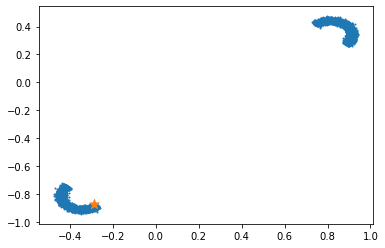

In [10]:

plt.scatter(ref_posterior[:,0],ref_posterior[:,1],s=1)

plt.scatter(true_theta[0],true_theta[1],marker='*',s=100)

In [93]:
#parameters for perturbation
sigma_min = 0.01
sigma_max = 1
num_levels= 10

device = torch.device('cuda')

sigmas = torch.tensor(np.exp(np.linspace(np.log(sigma_max), np.log(sigma_min), num_levels))).float().to(device)


In [94]:
# batch_size = 10000
# from torch.utils.data import TensorDataset
# dataset=TensorDataset(data)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, drop_last = True)
# dataloader for data
# dataiterator = iter(dataloader)

In [95]:
# Our approximation model
model = ConditionalModel(num_levels,x_dim=2,x_cond_dim=2).to(device)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [96]:
epochs=5000
# batch = (torch.tensor(samples, dtype=torch.float32).to(device),torch.tensor(thetas, dtype=torch.float32).to(device)
samples=samples.to(device)
thetas=thetas.to(device)
for epoch in range(epochs):
    # for batch in dataloader:

        # batch = batch[0].to(device)

    labels = torch.randint(0, len(sigmas), (samples.shape[0],)).to(device)
    loss = anneal_dsm_score_estimation(model=model,samples=thetas, samples_cond=samples, labels=labels, sigmas=sigmas)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if ((epoch % 1000) == 0):
        print(loss.item())

1.0390878915786743


0.4542235732078552
0.4148412346839905
0.4097554087638855
0.39166560769081116


(-1.0, 1.0)

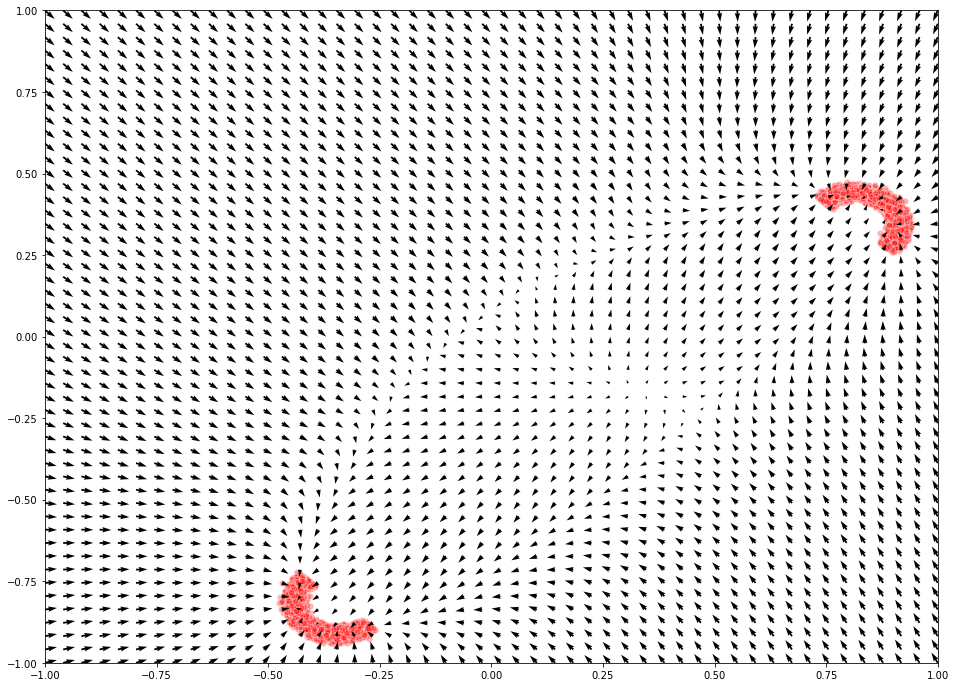

In [98]:
xx = np.stack(np.meshgrid(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50)), axis=-1).reshape(-1, 2)
# xx = np.stack(np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50)), axis=-1).reshape(-1, 2)
labels = torch.ones(xx.shape[0]).long().to(device)*9
sample_cond = torch.tensor(np.repeat(obs[None,:],xx.shape[0],axis=0),dtype=torch.float32).to(device)

scores = model(torch.tensor(xx).float().to(device),sample_cond, labels).detach().cpu().numpy()
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*ref_posterior.T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

In [105]:
# parameters for sampling

eps = 1e-5
n_steps = num_levels
annealed_step = 10000
sampling_number = 10000
only_final = False

init_point=torch.randn(sampling_number,2).to(device)
sample_cond=torch.tensor(np.repeat(obs[None,:],sampling_number,axis=0),dtype=torch.float32).to(device)

dynamic = annealed_langevin_dynamic(
    sigma_min, sigma_max, n_steps, annealed_step, model,init_point,sample_cond, device,eps=1e-4)

tensor([1.0000e+00, 3.5938e-01, 1.2915e-01, 4.6416e-02, 1.6681e-02, 5.9948e-03,
        2.1544e-03, 7.7426e-04, 2.7826e-04, 1.0000e-04], device='cuda:0')


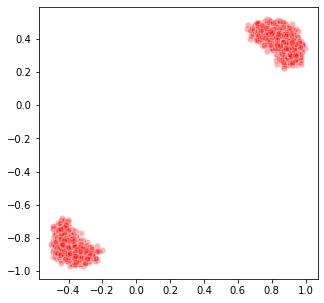

In [106]:

plt.figure(figsize=(5,5))
plt.scatter(*dynamic[-1].cpu().numpy().T , alpha=0.3, color='red', edgecolor='white', s=40)